# Exercises on Frequent Subgraph Mining

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tabulate import tabulate

## Exercise 1 - DFS codes
### Part A:

Consider the graph illustrated in Figure 1 and its DFS traversal:

<div style="margin: 0 auto; padding: 1em; text-align: center; max-width: 500px;">
    <img src="graphics/graph_dfs.jpg" />
    <p><b>Figure 1:</b> DFS traversal on graph. 
</div>

The figure already lists some precedence relationships among edges in this DFS traversal, along with the ordering rule by which they hold. As a reminder, for $e_1 = (i_1, j_1), e_2 = (i_2, j_2)$, the following ordering rules hold:

1. If $i_1 = i_2$ and $j_1 < j_2 \Rightarrow e_1 < e_2$ 
2. If $i_1 < j_1$ and $j_1 = i_2 \Rightarrow e_1 < e_2$
3. If $e_1 < e_2$ and $e_2 < e_3 \Rightarrow e_1 < e_3$  (transitive property)

Complete the list of precedence relationships and rules by which they hold.

### Part B:

Apart from the DFS traversal examined in the above and the corresponding code, the same graph has other DFS codes as well. Figure 2 below shows two other cases.

<div style="margin: 0 auto; padding: 1em; text-align: center; max-width: 500px;">
    <img src="graphics/graph2_dfs.jpg" />
    <p><b>Figure 2:</b> DFS traversal on graph. 
</div>

Write the DFS code of the two rightmost graphs in the Figure.

### Part C:

Find the minimal DFS code of the same graph by lexicographic ordering. (hint: see slides)

### Part D:

Consider the following mutation of labels in the above graph: all ‘a’ labels are turned to ‘b’ and ‘b’ labels are turned to ‘a’ (i.e., ‘a’ and ‘b’ labels swap values). Find the minimal DFS code of the new, mutated graph.

## Exercise 2 (min DFS code generation).

Implement an algorithm that finds the minimum DFS-code of a given graph. Hint: You may extract such an algorithm from this [gSpan code](https://github.com/LasseRegin/gSpan).

Note that we only need to generate a minimum DFS-code for the whole graph, rather than exhaustively generating all the DFS codes for its subgraphs, as gSpan does.

Let's build the graph corresponding to Figure 1 and Figure 2, which we can use to test our implementation.

First, we have a graph and some helper function.

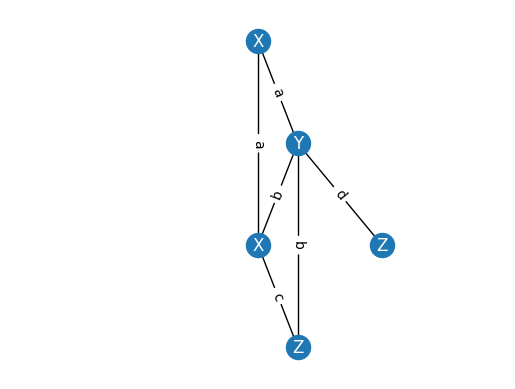

In [3]:
# Defining the graph (with labels)
G = nx.Graph()
G.add_node(4, label='Z')
G.add_node(0, label='X')
G.add_node(2, label='X')
G.add_node(1, label='Y')
G.add_node(3, label='Z')
G.add_edge(0, 1, label='a')
G.add_edge(2, 3, label='c')
G.add_edge(0, 2, label='a')
G.add_edge(1, 3, label='b')
G.add_edge(1, 4, label='d')
G.add_edge(1, 2, label='b')
pos = {0: (0., 1.), 1: (0.08, 0.75), 2: (0., 0.5), 3: (0.08, 0.25), 4: (0.25, 0.5)}  # Layout for plotting

# Plotting the graph
def plot_graph_with_labels(G, pos, ax, label_key='label'):
    # Draw nodes and edges (without labels)
    nx.draw(G, pos=pos, ax=ax) 
    # Draw node labels
    nx.draw_networkx_labels(G, pos=pos, labels={k:v for k, v in G.nodes(data=label_key)}, font_color='white') 
    # Draw edge labels
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels={tuple(pos): v for *pos, v in G.edges(data=label_key)}, font_color='black')
    
fig, ax = plt.subplots()
ax.set_xlim([-0.5, 0.5])
plot_graph_with_labels(G, pos, ax)

In [4]:
# A couple of python tricks: 
print("1. You can get the label of a node as follows:")
print("Label for node 1: ", G.nodes[1]['label'])

print("---")
print("2. You can get the nodes and associated labels as follows:")
for n, l in G.nodes(data='label'):
    print(n, l)
    
print("---")
print("3. You can get the edge labels as follows:")
print("Label for edge (1, 3): ", G.edges[(1, 3)]['label'])

print("---")
print("4. You can get all edges and their labels as follows: ")
for i, j, l in G.edges(data='label'):
    print("Node (%d, %d) has label %s" % (i, j, l))
    
print("---")
print("5. Neighbors of a node n can be found as follows:")
neighbors = list(G.neighbors(1))
neighbors_with_labels = [(n, G.nodes[n]['label']) for n in G.neighbors(1)]
print(neighbors, neighbors_with_labels)

print("You could even define a function that sorts them")
def neighbors(G, n):
    """ Returns list of tuples of (node_idx, neighbor_idx, 'edge_label', 'neighbor_label')
        sorted lexicographically by labels
    """
    edges = G.edges
    nodes = G.nodes
    
    neighbors = [(n, n_, edges[(n, n_)]['label'], nodes[n_]['label']) for n_ in G.neighbors(n)]
    neighbors = sorted(neighbors, key=lambda x: tuple(x[2:]))
    return neighbors

print(neighbors(G, 1))

1. You can get the label of a node as follows:
Label for node 1:  Y
---
2. You can get the nodes and associated labels as follows:
4 Z
0 X
2 X
1 Y
3 Z
---
3. You can get the edge labels as follows:
Label for edge (1, 3):  b
---
4. You can get all edges and their labels as follows: 
Node (4, 1) has label d
Node (0, 1) has label a
Node (0, 2) has label a
Node (2, 3) has label c
Node (2, 1) has label b
Node (1, 3) has label b
---
5. Neighbors of a node n can be found as follows:
[0, 3, 4, 2] [(0, 'X'), (3, 'Z'), (4, 'Z'), (2, 'X')]
You could even define a function that sorts them
[(1, 0, 'a', 'X'), (1, 2, 'b', 'X'), (1, 3, 'b', 'Z'), (1, 4, 'd', 'Z')]


In [9]:
def dfs(G, v): # Performs dfs search on G starting in node v. Builds and returns dfs code
    node_idx      = dict.fromkeys(G.nodes(), -1)      # Map that keeps order of discovery of each node.
    nodes_visited = dict.fromkeys(G.nodes(), False)   # Map that keeps visited nodes to not recurse forever.
    edges_visited = dict.fromkeys(G.edges(), False)   # Map that keeps handled edges (already output).
    
    node_idx[v]         = 0     # First node get idx 0
    nodes_visited[v]    = True  # Mark first node visited
     
    # Function to produce a code tuple from two node indices, i.e., (i, j, Li, Lij, Lj)
    tup = lambda fr, to: (node_idx[fr], node_idx[to], G.nodes[fr]['label'], G.edges[(fr, to)]['label'], G.nodes[to]['label'])
    
    # Shorthand for marking and reading marked edges. Solves issue with nodes that can be ordered arbitratily (i, j) or (j, i)
    def mark_edge(v1, v2):
        if (v1, v2) in edges_visited: edges_visited[(v1, v2)] = True
        else:                         edges_visited[(v2, v1)] = True
    edge_marked = lambda v1, v2: edges_visited.get((v1, v2), False) or edges_visited.get((v2, v1), False)
    
    # Initialize edge queue by edges from starting node in lexicographic order.
    queue    = neighbors(G, v)[::-1] # Reverse order to take lexicographically smallest first
    # [e1, e2, .... ei-1] + [ v.edges (sorted) ]
    code     = [] # Output code
    
    k = 1 # Counter for node idx
    while len(queue) > 0: # Visit all edges DFS
        node_from, curr_node, *_ = queue.pop() # Take last element from queue
        
        if edge_marked(node_from, curr_node): continue # Don't use the same edge multiple times
        mark_edge(node_from, curr_node) # Mark edge as visited
        
        if nodes_visited[curr_node]:                  # Backward node
            code.append(tup(node_from, curr_node))
            
        else:                                         # Forward edge => we need to add curr_nodes's edges to the queue
            node_idx[curr_node] = k
            nodes_visited[curr_node]  = True
            k += 1
            
            code.append(tup(node_from, curr_node))
            
            edges = [ (not nodes_visited[t[1]], *t) for t in neighbors(G, curr_node) ] # Add `visited` to tuple, to prioritize backward edges first
            edges = sorted( edges )
            queue += [t[1:] for t in edges][::-1] # Remove `visited` again
        
    return code
    

# print dfs codes for different starting nodes
print("Node 0\n", tabulate(dfs(G, 0)))
print("Node 1\n", tabulate(dfs(G, 1)))
print("Node 2\n", tabulate(dfs(G, 2)))
print("Node 3\n", tabulate(dfs(G, 3)))
print("Node 4\n", tabulate(dfs(G, 4)))



Node 0
 -  -  -  -  -
0  1  X  a  X
1  2  X  b  Y
2  0  Y  a  X
2  3  Y  b  Z
3  1  Z  c  X
2  4  Y  d  Z
-  -  -  -  -
Node 1
 -  -  -  -  -
0  1  Y  a  X
1  2  X  a  X
2  0  X  b  Y
2  3  X  c  Z
3  0  Z  b  Y
0  4  Y  d  Z
-  -  -  -  -
Node 2
 -  -  -  -  -
0  1  X  a  X
1  2  X  a  Y
2  0  Y  b  X
2  3  Y  b  Z
3  0  Z  c  X
2  4  Y  d  Z
-  -  -  -  -
Node 3
 -  -  -  -  -
0  1  Z  b  Y
1  2  Y  a  X
2  3  X  a  X
3  1  X  b  Y
3  0  X  c  Z
1  4  Y  d  Z
-  -  -  -  -
Node 4
 -  -  -  -  -
0  1  Z  d  Y
1  2  Y  a  X
2  3  X  a  X
3  1  X  b  Y
3  4  X  c  Z
4  1  Z  b  Y
-  -  -  -  -


Then, we need to implement ordering rules.

In [16]:
def compare(c1, c2): # Check if c1 < c2 for dfs codes c1, c2
    """
        Function for comparing 2 dfs codes lexicographically. Defines sorting of dfs codes.
        Input:
            c1:   list of tuples [(i, j, L_i, L_{ij}, L_j), ...]
            c2:   list of tuples [(i, j, L_i, L_{ij}, L_j), ...]
        Output:
            1 if c1 > c2, -1 if c1 < c2, 0 if c1 == c2  
    """
    if len(c1) != len(c2): raise ValueError("Codes should be of same length")
        
    # TODO Your code here
    # Hint: Check slides for definition of comparrison of dfs codes.

    print(c1)
    print(c2)

    for i in range(len(c1)):
        t1 = c1[i]
        t2 = c2[i]

        if t1[0] == t2[0]:
            continue

        i1, j1, Li1, Lij1, Lj1 = t1
        i2, j2, Li2, Lij2, Lj2 = t2

        if j1 == j2:
            return -1 if (i1 < i2) or (i1 == i2 and (Li1, Lij1, Lj1) < (Li2, Lij2, Lj2)) else 1
        
        if i1 == i2:
            return -1 if (j1 < j2 or (j1 == j2 and Lij1 < Lij2)) else 1
        
        if j1 < i1: return -1
        elif j2 < i2: return 1

    # TODO Your code here
        
    return 0 # codes are identical
 

Finally, compare all dfs code given by *dfs()*.

In [17]:
def min_dfs_code(G):
    """
        Input:
            G:   A networkx graph.
        Output:
            min_dfs: A list of tuples [(i, j, L_i, L_{ij}, L_j), ...]
            min_node: Index of node with minimum dfs code
    """
    min_dfs = []
    min_node = 0
    # TODO Your code here

    for node in G.nodes():
    
        dfs_code = dfs(G, node)

        if len(min_dfs) == 0:
            min_dfs = dfs_code
            min_node = node
            continue

        if compare(dfs_code, min_dfs) == -1:
            min_dfs = dfs_code
            min_node = node

    # TODO Your code here
    return min_dfs, min_node

In [18]:
min_code, min_node = min_dfs_code(G)

print("Min node is: ", min_node)
print("Code: ")
print(tabulate(min_code, headers=['i', 'j', 'Li', 'Lij', 'Lj']))

[(0, 1, 'X', 'a', 'X'), (1, 2, 'X', 'b', 'Y'), (2, 0, 'Y', 'a', 'X'), (2, 3, 'Y', 'b', 'Z'), (3, 1, 'Z', 'c', 'X'), (2, 4, 'Y', 'd', 'Z')]
[(0, 1, 'Z', 'd', 'Y'), (1, 2, 'Y', 'a', 'X'), (2, 3, 'X', 'a', 'X'), (3, 1, 'X', 'b', 'Y'), (3, 4, 'X', 'c', 'Z'), (4, 1, 'Z', 'b', 'Y')]
[(0, 1, 'X', 'a', 'X'), (1, 2, 'X', 'a', 'Y'), (2, 0, 'Y', 'b', 'X'), (2, 3, 'Y', 'b', 'Z'), (3, 0, 'Z', 'c', 'X'), (2, 4, 'Y', 'd', 'Z')]
[(0, 1, 'Z', 'd', 'Y'), (1, 2, 'Y', 'a', 'X'), (2, 3, 'X', 'a', 'X'), (3, 1, 'X', 'b', 'Y'), (3, 4, 'X', 'c', 'Z'), (4, 1, 'Z', 'b', 'Y')]
[(0, 1, 'Y', 'a', 'X'), (1, 2, 'X', 'a', 'X'), (2, 0, 'X', 'b', 'Y'), (2, 3, 'X', 'c', 'Z'), (3, 0, 'Z', 'b', 'Y'), (0, 4, 'Y', 'd', 'Z')]
[(0, 1, 'Z', 'd', 'Y'), (1, 2, 'Y', 'a', 'X'), (2, 3, 'X', 'a', 'X'), (3, 1, 'X', 'b', 'Y'), (3, 4, 'X', 'c', 'Z'), (4, 1, 'Z', 'b', 'Y')]
[(0, 1, 'Z', 'b', 'Y'), (1, 2, 'Y', 'a', 'X'), (2, 3, 'X', 'a', 'X'), (3, 1, 'X', 'b', 'Y'), (3, 0, 'X', 'c', 'Z'), (1, 4, 'Y', 'd', 'Z')]
[(0, 1, 'Z', 'd', 'Y'), (1,

#### Exercise 2.1
Unfortunately, *dfs()* is incorrect (although it works fine with above graph). Can you give a counterexample and point out why it is wrong?